# Module 1.8: Timeseries Diagnostics

> **Goal:** Explore characteristics of the M5 dataset using tsfeatures + tsforge.

This module teaches you to:
1. Load data
2. Compute diagnostics at the most granular "unique_id" level. 
3. Motivate the focus on the "Lie Detector Six" metric set.
    * getting a feel for the forecastability, quality and characteristics of the data BEFORE we start forecasting.


## 1. Setup

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
from pathlib import Path
from tsforge import load_m5
import tsforge as tsf
import seaborn as sns

# Configuration
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

In [141]:
# Define directories
DATA_DIR = Path('./data')
OUTPUT_DIR = Path('./output')
OUTPUT_DIR.mkdir(exist_ok=True)

print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Data directory: data
Output directory: output


## 2. Load M5 Data 

The M5 dataset comes in **wide format** (great for storage, terrible for forecasting):
- One row per item-store
- 1,941 columns named `d_1`, `d_2`, ..., `d_1941` representing daily sales

Forecasting models need **long format**:
- One row per item-store-date combination
- Columns: `unique_id`, `ds` (date), `y` (sales)

**Good news:** TSForge's `load_m5()` handles this transformation automatically.

In [142]:
# Load clean M5 dataset from datasetsforecast package
print("Loading M5 from datasetsforecast package...")
Y_df = tsf.load_m5(DATA_DIR,include_hierarchy=True,create_unique_id=True)
print(f"\n✓ Loaded clean M5 from datasetsforecast")


Loading M5 from datasetsforecast package...
LOADING M5 DATA
✓ M5 cache detected. Loading from local files...
✓ Loaded in 0.8s
  Shape: 47,649,940 rows × 3 columns
  Memory: 638.1 MB
  Columns: unique_id, ds, y
  Returning: Y_df, X_df, S_df (all 3 dataframes)

🏗️ Expanding hierarchy...
  Expanding hierarchy via S_df merge...
  ✓ Added hierarchy columns: ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']

🔑 Creating unique_id...
Created unique_id: 30,490 unique series
Sample: FOODS_1_001_CA_1

LOAD COMPLETE
  Shape: 47,649,940 rows × 8 columns
  Columns: ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id', 'ds', 'y', 'unique_id']
  Applied: hierarchy expanded, unique_id created

✓ Loaded clean M5 from datasetsforecast


* just as we did in past videos, we transform the data to long format which is standard for nixtla and other libraries. 

In [143]:
# Preview the forecasting-ready format
print("Sales data structure:")
print(Y_df.head(10))

print("\nData types:")
print(Y_df.dtypes)

print("\nBasic stats:")
print(Y_df['y'].describe())

Sales data structure:
       item_id  dept_id cat_id store_id state_id         ds    y  \
0  FOODS_1_001  FOODS_1  FOODS     CA_1       CA 2011-01-29  3.0   
1  FOODS_1_001  FOODS_1  FOODS     CA_1       CA 2011-01-30  0.0   
2  FOODS_1_001  FOODS_1  FOODS     CA_1       CA 2011-01-31  0.0   
3  FOODS_1_001  FOODS_1  FOODS     CA_1       CA 2011-02-01  1.0   
4  FOODS_1_001  FOODS_1  FOODS     CA_1       CA 2011-02-02  4.0   
5  FOODS_1_001  FOODS_1  FOODS     CA_1       CA 2011-02-03  2.0   
6  FOODS_1_001  FOODS_1  FOODS     CA_1       CA 2011-02-04  0.0   
7  FOODS_1_001  FOODS_1  FOODS     CA_1       CA 2011-02-05  2.0   
8  FOODS_1_001  FOODS_1  FOODS     CA_1       CA 2011-02-06  0.0   
9  FOODS_1_001  FOODS_1  FOODS     CA_1       CA 2011-02-07  0.0   

          unique_id  
0  FOODS_1_001_CA_1  
1  FOODS_1_001_CA_1  
2  FOODS_1_001_CA_1  
3  FOODS_1_001_CA_1  
4  FOODS_1_001_CA_1  
5  FOODS_1_001_CA_1  
6  FOODS_1_001_CA_1  
7  FOODS_1_001_CA_1  
8  FOODS_1_001_CA_1  
9  FOODS_

In [144]:
# two very important preprocessing steps

# get cols to groupby 
group_cols = Y_df.select_dtypes(include=['object','category']).columns.tolist()

# here we get static df to join to the weekly dataframe m:1
static_df = Y_df[group_cols].drop_duplicates(subset='unique_id')

#1 trim leading zeros 
min_dates = Y_df.query("y > 0").groupby('unique_id')['ds'].min().to_dict()

df_trim = Y_df.loc[Y_df['ds'] >= Y_df['unique_id'].map(min_dates)]

print(f'Dropped {Y_df.shape[0] - df_trim.shape[0]} rows by removing leading zeros')

# 2 aggregate to weekly granularity
weekly_df = df_trim.groupby('unique_id').resample("W-MON", on="ds")[["y"]].sum().reset_index()

Dropped 0 rows by removing leading zeros


* validate the target and check series for time-gaps or duplicates

In [145]:
# Check for duplicates
duplicates = Y_df.duplicated(subset=['unique_id', 'ds']).sum()
print(f"Duplicate (unique_id, ds) pairs: {duplicates}")

# Check for nulls
print(f"\nNull values:")
print(Y_df.isnull().sum())

# Validate date continuity (sample one series)
sample_series = Y_df[Y_df['unique_id'] == Y_df['unique_id'].iloc[0]].copy()
sample_series = sample_series.sort_values('ds')
date_diff = sample_series['ds'].diff().dt.days
gaps = (date_diff > 1).sum()
print(f"\nDate gaps in sample series: {gaps}")

if duplicates == 0 and Y_df.isnull().sum().sum() == 0 and gaps == 0:
    print("\n✓ Base dataset validation PASSED")
else:
    print("\n⚠ Base dataset has issues - investigate before proceeding")

Duplicate (unique_id, ds) pairs: 0

Null values:
item_id      0
dept_id      0
cat_id       0
store_id     0
state_id     0
ds           0
y            0
unique_id    0
dtype: int64

Date gaps in sample series: 0

✓ Base dataset validation PASSED


Notebook agenda 

* Reconfirm the unique_id definition
* Compute tsfeatures + tsforge diagnostics per unique_id
* Highlight the “Lie Detector Six”

In [146]:
# compute some datetime diagnostics  
date_tbl = tsf.eda.datetime_diagnostics(df=weekly_df,id_col='unique_id',date_col='ds')

# describe the datetime diagnostics from tsforge 
date_tbl.describe() # it looks like we have a variety of length series! 

,start_date,end_date,n_obs,span_days,obs_per_year,n_gaps,pct_missing
count,30490,30490,30490.000000,30490.000000,30490.000000,30490.0,30490.0
mean,2012-03-12 19:36:16.530009856,2016-06-20 00:00:00,223.883306,1560.183142,52.455679,0.0,0.0
min,2011-01-31 00:00:00,2016-06-20 00:00:00,18.000000,119.000000,52.364260,0.0,0.0
25%,2011-01-31 00:00:00,2016-06-20 00:00:00,172.000000,1197.000000,52.364260,0.0,0.0
50%,2011-07-11 00:00:00,2016-06-20 00:00:00,259.000000,1806.000000,52.380814,0.0,0.0
75%,2013-03-11 00:00:00,2016-06-20 00:00:00,282.000000,1967.000000,52.483709,0.0,0.0
max,2016-02-22 00:00:00,2016-06-20 00:00:00,282.000000,1967.000000,55.247899,0.0,0.0
std,NaN,NaN,68.208442,477.459092,0.167962,0.0,0.0


In [147]:
from tsforge.eda import lumpiness, permutation_entropy, MI_top_k_lags, stl_features,ADI,statistics

# using nixtla's tsfeatures 
id_lvl_feats = tsf.eda.tsfeatures(

    ts = weekly_df,
    # frequency of data is weekly, so here we input 52     
    freq=52,

    # COMPUTE LIE detector six 
    features=[
        statistics,
        lumpiness, # variance of variances 
        permutation_entropy, # permutation entropy 
        MI_top_k_lags, # sum of MI over top 5 lags 
        stl_features, # STL decomposition Features (Trend, Seasonal Strength)
        ADI, # Avg Demand Interval
        ],

        scale=False # ENSURE YOU TURN THIS OFF for accurate statistics, otherwise outputs are standard scaled for model training.. 
)

* taking a closter look at the table we the "Lie Detector 6". 

    - Lumpiness: Variance of Variances 
    - Entropy (Permutation Entropy)
    - Seasonal Strength 
    - Trend Strength
    - MI Top K Lags: Mutual Information Top K Lags (K = 5)
        - for more clarity this is the sum of the Mutual Information of the top 5 lags from lags 1-freq
    - ADI: Average Demand Interval (time between demands)

In [148]:
id_lvl_feats[["unique_id","lumpiness", "permutation_entropy", "seasonal_strength", "trend", "MI_top_k_lags", "adi"]].head()

,unique_id,lumpiness,permutation_entropy,seasonal_strength,trend,MI_top_k_lags,adi
0,FOODS_1_001_CA_1,66.523422,0.969224,0.374705,0.202104,0.297398,1.114625
1,FOODS_1_001_CA_2,313.632263,0.974546,0.375386,0.199255,0.146094,1.110236
2,FOODS_1_001_CA_3,42.807152,0.984964,0.401933,0.181853,0.141153,1.110236
3,FOODS_1_001_CA_4,1.556300,0.930857,0.469487,0.096339,0.277497,1.258929
4,FOODS_1_001_TX_1,22.262094,0.975693,0.353986,0.243264,0.162757,1.189873


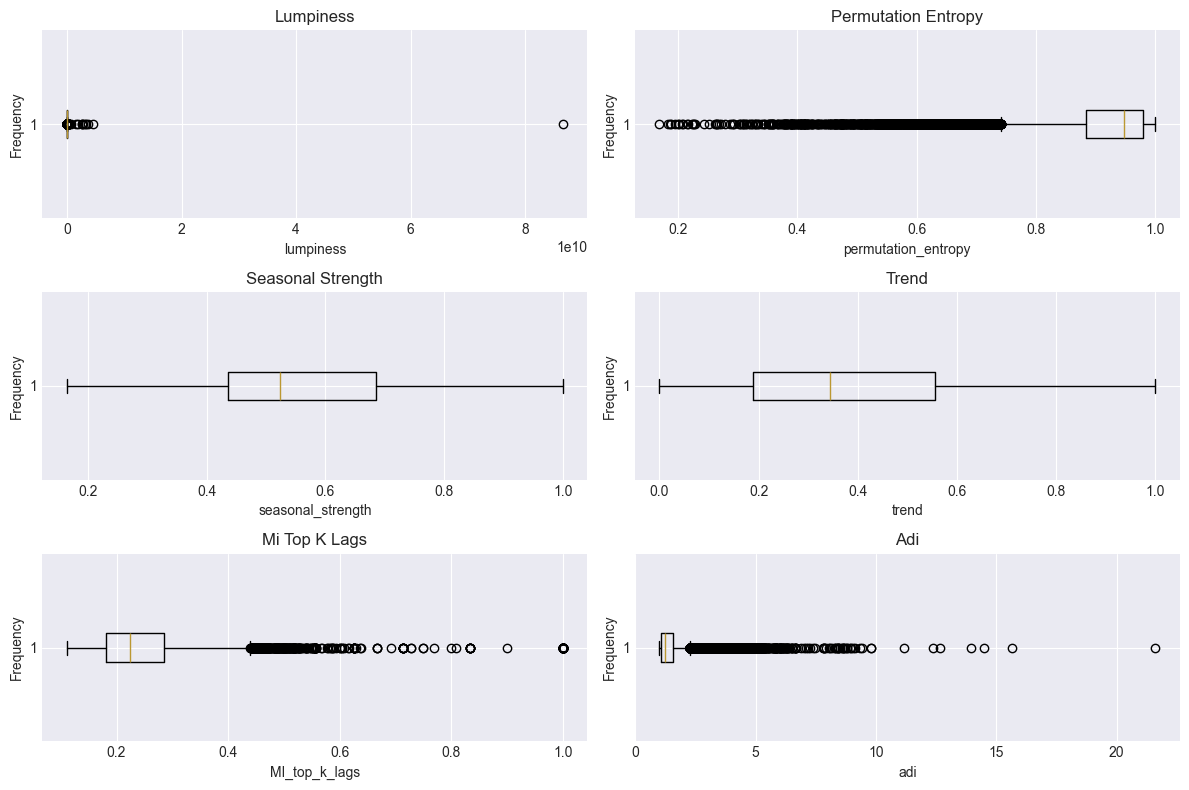

In [157]:
metrics = ['lumpiness', 'permutation_entropy', 'seasonal_strength', 'trend','MI_top_k_lags','adi']
res = id_lvl_feats[metrics].describe()
res

# Distribution overview
fig, axes = plt.subplots(3, 2, figsize=(12, 8))
for ax, col in zip(axes.ravel(), metrics):
    ax.boxplot(id_lvl_feats[col].dropna(),vert=False)
    ax.set_title(col.replace('_', ' ').title())
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


* now lets plot series that are high in each characteristic

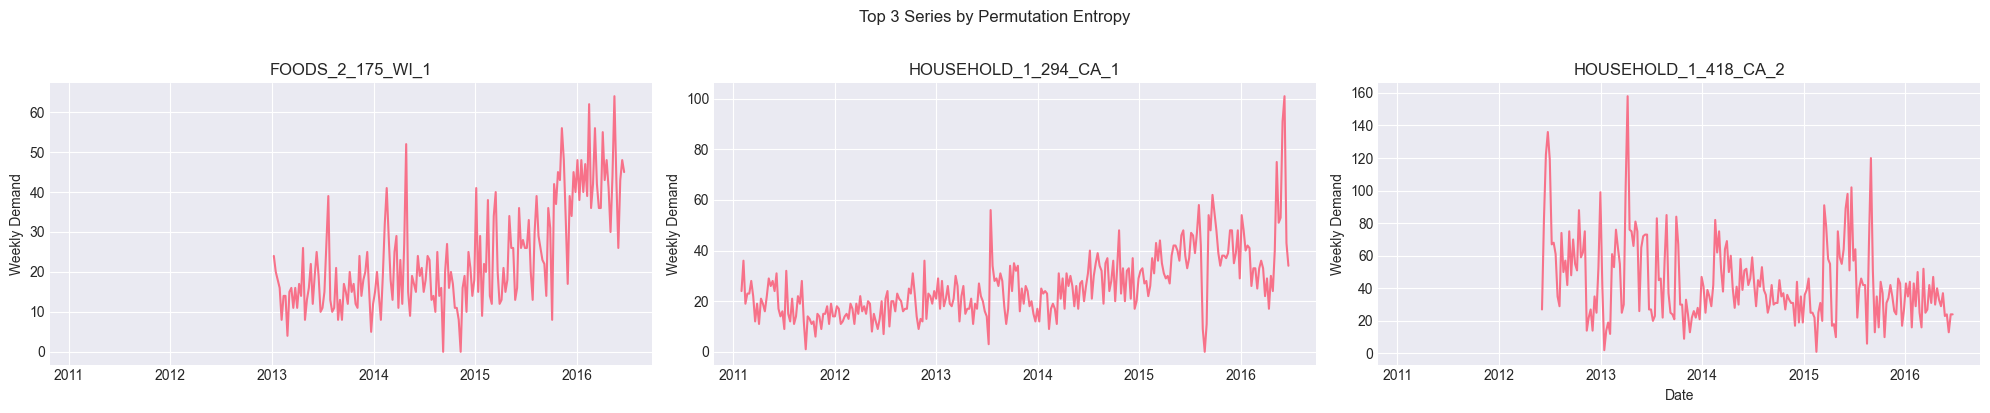

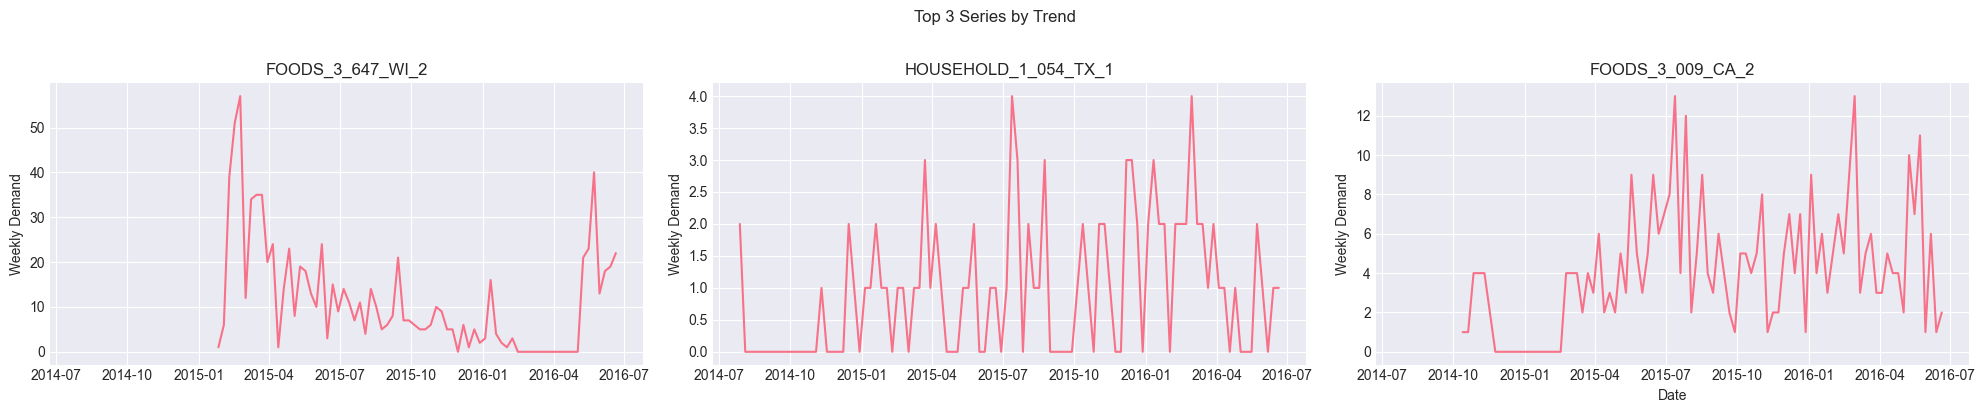

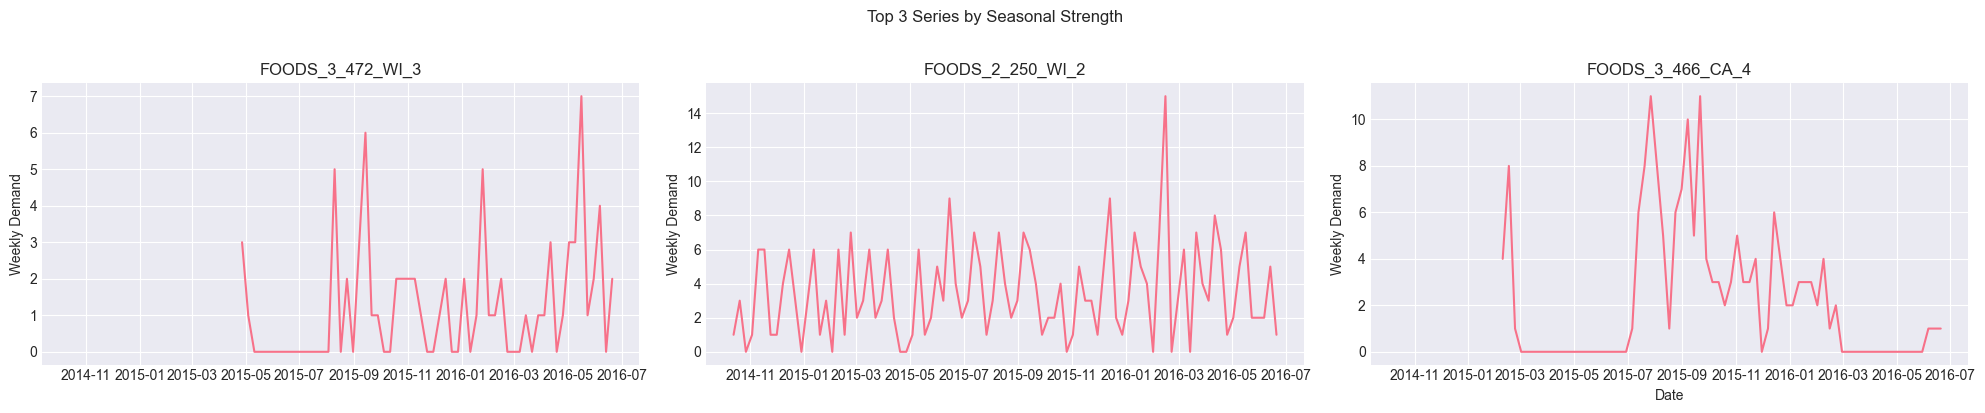

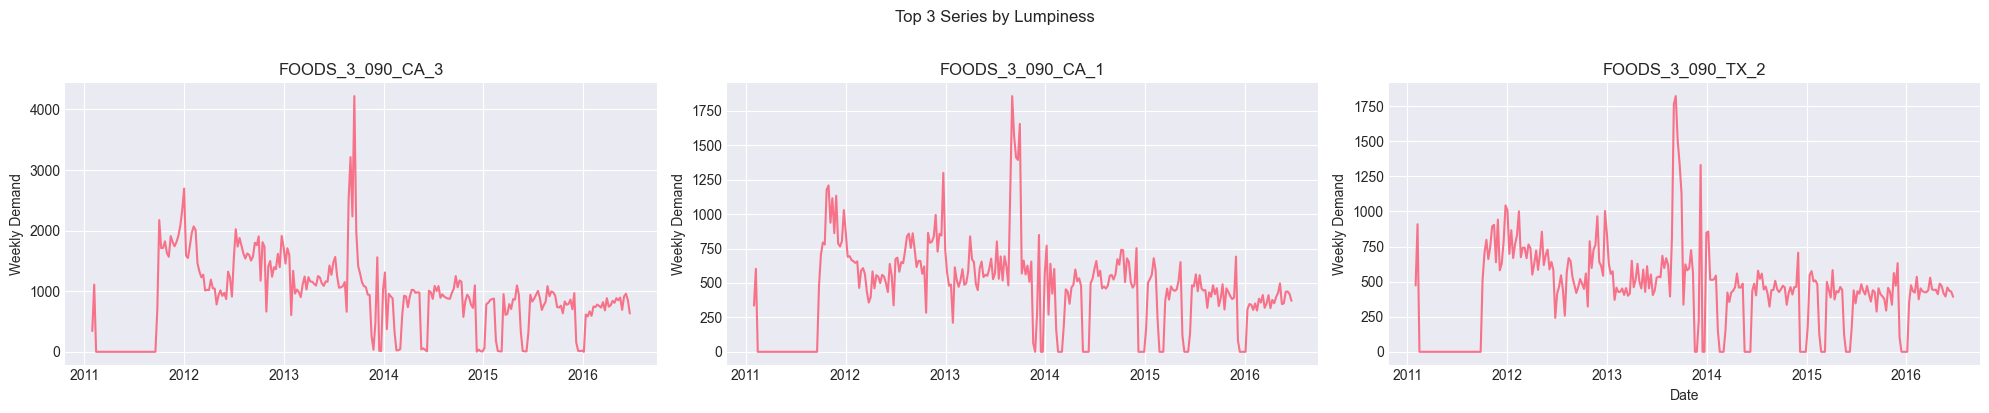

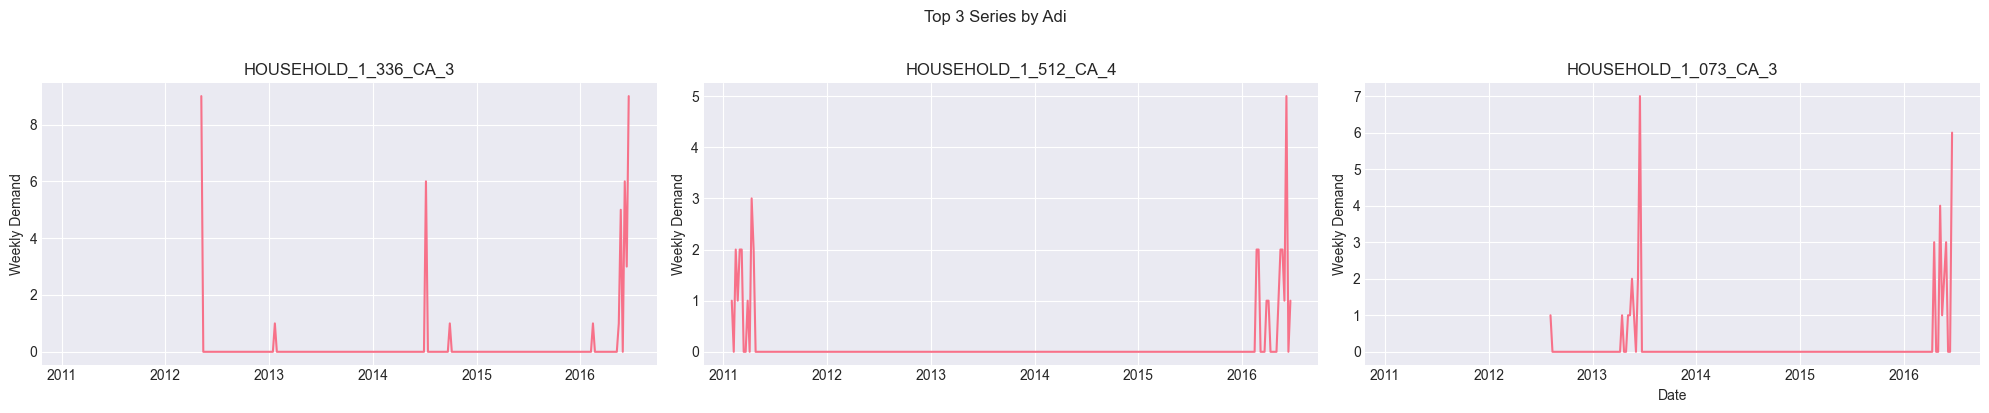

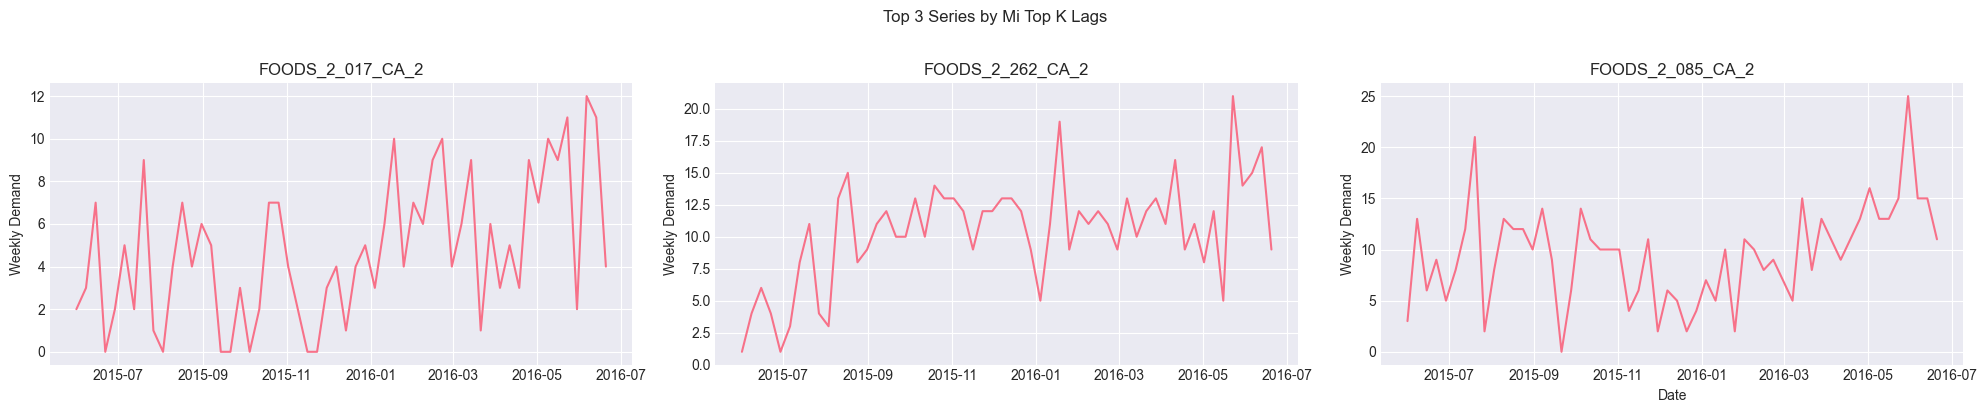

In [159]:
# plot series with strong seasonal or trend strength..

TOP_N = 3
min_series_length = 52 # show series with atleast one year of obs to look at things

for metric in ['permutation_entropy','trend','seasonal_strength','lumpiness','adi','MI_top_k_lags']:

    # lets join our datetable! to filter for n_obs >= 52... 
    available = id_lvl_feats[["unique_id", metric]].merge(date_tbl,on=['unique_id']).dropna()
    top_ids = available.sort_values(metric, ascending=False).head(TOP_N).reset_index(drop=True)

    fig, axes = plt.subplots(1, top_ids.shape[0], figsize=(20,4),sharex=True)
    if top_ids.shape[0] == 1:
        axes = [axes]

    for ax, row in zip(axes, top_ids.itertuples(index=False)):
        uid = row.unique_id
        series = weekly_df[weekly_df["unique_id"] == uid].sort_values("ds")
        ax.plot(series["ds"], series["y"])
        ax.set_title(uid)
        ax.set_ylabel("Weekly Demand")
        ax.legend()

    axes[-1].set_xlabel("Date")
    fig.suptitle(f"Top {top_ids.shape[0]} Series by {metric.replace('_', ' ').title()}", y=1.02)
    fig.tight_layout()
    fig.show()

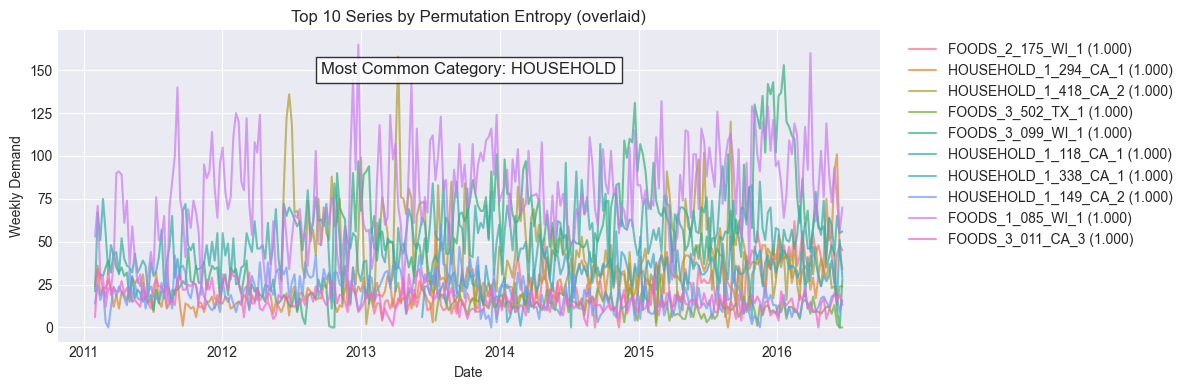

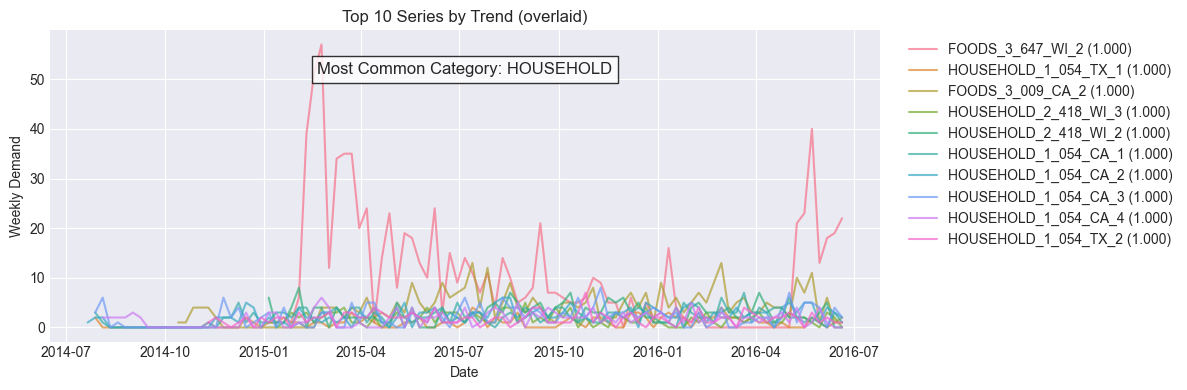

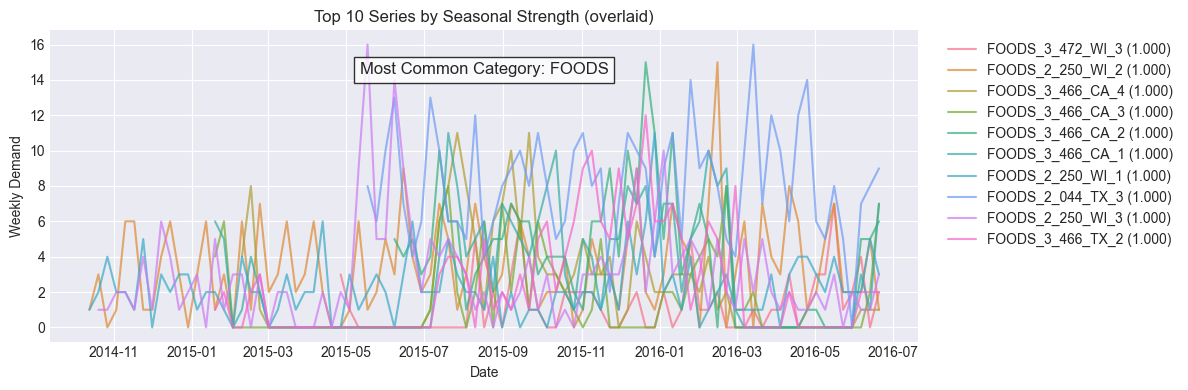

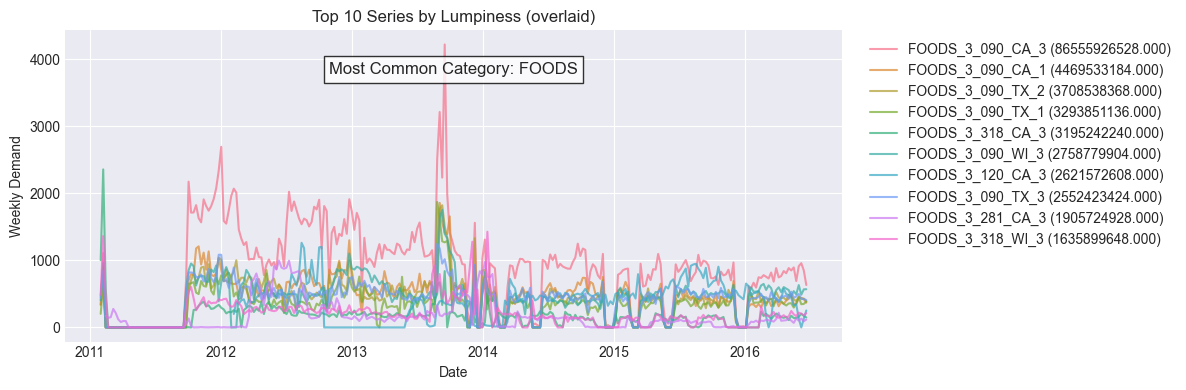

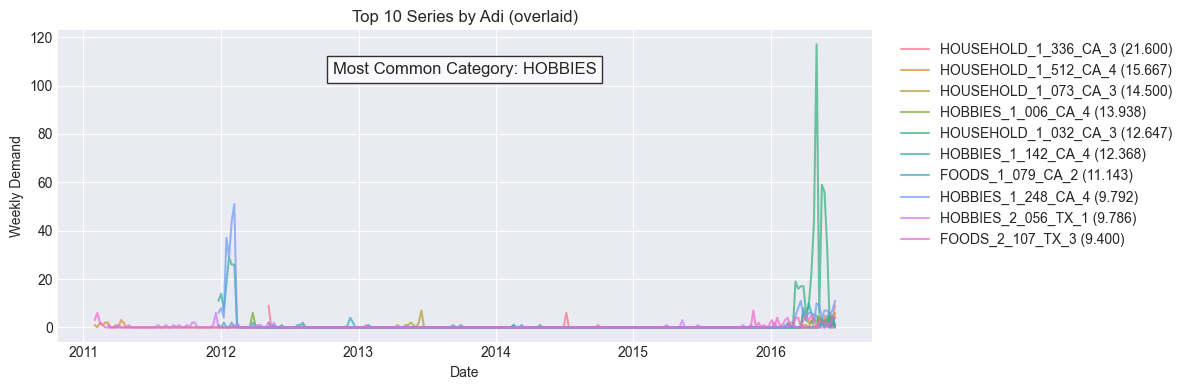

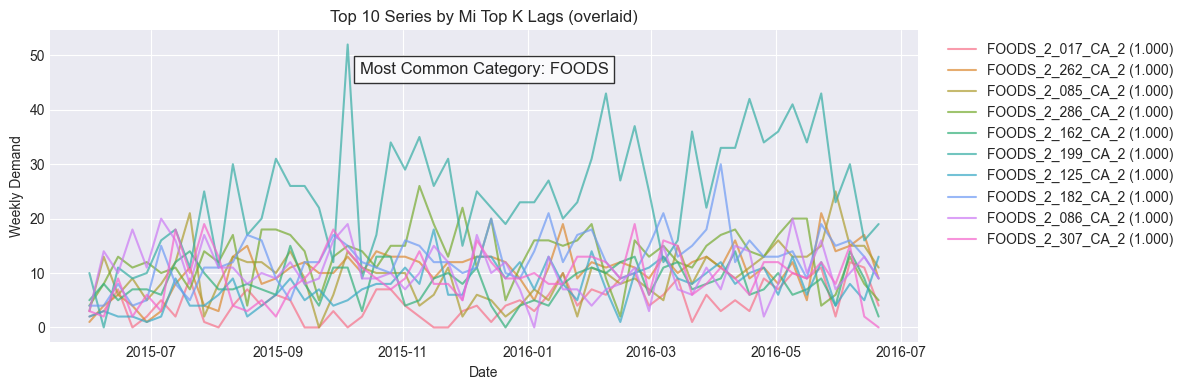

In [160]:
# plot top-N series overlaid for each metric to compare shapes
TOP_N = 10
min_series_length = 52
metrics = ["permutation_entropy", "trend","seasonal_strength", "lumpiness", "adi", "MI_top_k_lags"]
colors = sns.color_palette("husl", TOP_N)

for metric in metrics:
    available = id_lvl_feats[["unique_id", metric]].dropna()
    top_ids = available.sort_values(metric, ascending=False).head(TOP_N)

    if top_ids.empty:
        print(f"No eligible series for {metric}")
        continue

    fig, ax = plt.subplots(figsize=(12, 4))
    for color, row in zip(colors, top_ids.itertuples(index=False)):
        uid = row.unique_id
        series = weekly_df[weekly_df["unique_id"] == uid].sort_values("ds")
        ax.plot(series["ds"], series["y"], label=f"{uid} ({row[1]:.3f})", color=color, alpha=0.7)

    # plot the most common category
    most_common_category = (
        weekly_df[weekly_df["unique_id"].isin(top_ids["unique_id"])]["unique_id"]
        .str.split("_", n=1, expand=True)[0]
        .mode()[0]
    )
    ax.text(
        s=f"Most Common Category: {most_common_category}",
        x=0.5,
        y=0.85,
        transform=ax.transAxes,
        ha="center",
        va="bottom",
        fontsize=12,
        bbox=dict(facecolor="white", alpha=0.8),
    )

    ax.set_title(f"Top {TOP_N} Series by {metric.replace('_', ' ').title()} (overlaid)")
    ax.set_ylabel("Weekly Demand")
    ax.set_xlabel("Date")
    ax.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


* as a little bonus, we can create a function to learn more about our high MI series, here is how we can do that efficiently! 

In [161]:
from sklearn.feature_selection import mutual_info_regression


def MI_top_k_lags_indices(x, freq):
    """get top 5 lag indices based on mutual information"""

    max_lag = min(freq, len(x) - 1)
    if max_lag < 1:
        return {"MI_top_k_lags_indices": np.nan}

    target = x[max_lag:]  # lag 0
    try:
        lag_matrix = np.column_stack(
            [
                x[max_lag - lag : len(x) - lag]  # shift by `lag`
                for lag in range(1, max_lag + 1)
            ]
        )

        mi_scores = mutual_info_regression(X=lag_matrix, y=target, random_state=42)

        top_k = min(5, len(mi_scores))
        top_idx = np.argsort(mi_scores)[-top_k:][::-1]
        top_lags = (top_idx + 1).tolist()
        return {"MI_top_k_lags_indices": top_lags}
    except Exception:
        return {"MI_top_k_lags_indices": np.nan}


In [162]:
from joblib import Parallel, delayed
import pandas as pd


def compute_mi_series(uid, series):
    # series is a 1-D pandas Series of y for that SKU
    mi_idx = MI_top_k_lags_indices(series.to_numpy(), freq=52).get("MI_top_k_lags_indices")
    return uid, mi_idx  # adjust to whatever MI_top_k_lags_indices returns


groups = weekly_df.groupby("unique_id")["y"]

results = Parallel(
    n_jobs=-1,  # use all cores; tweak if needed
    backend="loky",  # good default for CPU-bound work
    prefer="processes",
)(delayed(compute_mi_series)(uid, grp) for uid, grp in groups)

mi_df = pd.DataFrame(results, columns=["unique_id", "mi_indices"])


KeyboardInterrupt: 

<Axes: title={'center': 'Which 20 Lags Were Most Predictive Across All Series?'}, xlabel='Proportion of All Series', ylabel='Lag(y)'>

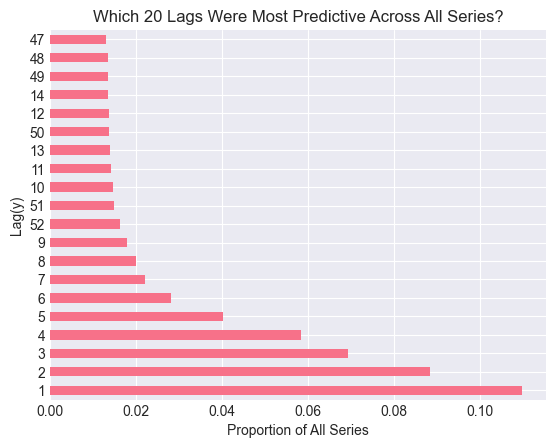

In [ ]:
# examine WHICH lags are most predictive using sister metric (Returns the 5 most predictive lags by MI)
pred_lag_df = mi_df.explode("mi_indices")


#
pred_lag_df['mi_indices'].value_counts(normalize=True)[:20].plot.barh(
    title='Which 20 Lags Were Most Predictive Across All Series?',
    xlabel='Proportion of All Series',
    ylabel='Lag(y)'
) # percentages instead of counts 

<Axes: title={'center': 'Which is Most Commonly the Most Predictive Singe Lag?'}, xlabel='Proportion of All Series', ylabel='Lag(y)'>

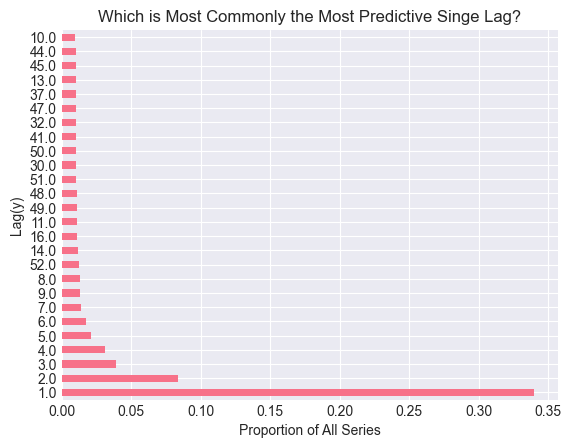

In [ ]:
mi_df['most_predictive_lag'] = mi_df["mi_indices"].str[0]


# no surprised here! 
mi_df["most_predictive_lag"].value_counts(normalize=True)[:10].plot.barh(
    title="Which is Most Commonly the Most Predictive Singe Lag?",
    xlabel="Proportion of All Series",
    ylabel="Lag(y)",
)  # percentages instead of counts

* in the next notebook we will use LLMs to help us analyze these key 6 indicators across the business hierarchy. So let's save our results!

In [ ]:
id_lvl_feats.to_parquet(
    OUTPUT_DIR / "uid_lvl_feats.parquet"
)